### Situação:

Usando os dados das licitações do ano de 2021, no Rio Grande do Sul, fazer uma análise dos principais itens licitados e das áreas que receberam maior investimento por meio de licitações

Link: http://dados.tce.rs.gov.br/dataset?groups=licitacoes&q=consolidado

Referências:

https://github.com/PatrickLdA/licitacoes-RS/blob/main/notebook.ipynb

https://medium.com/somos-tera/como-modelar-t%C3%B3picos-atrav%C3%A9s-de-latent-dirichlet-allocation-lda-atrav%C3%A9s-da-biblioteca-gensim-1fa17357ad4b

### Imports

In [182]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
#
import spacy 
import nltk

In [4]:
files = os.listdir('/2021')

In [5]:
files

['memcomissao.csv',
 'evento_lic.csv',
 'documento_lic.csv',
 'licitante.csv',
 'licitacao.csv',
 'item.csv',
 'pessoas.csv',
 'dotacao_lic.csv',
 'comissao.csv',
 'membrocons.csv',
 'proposta.csv',
 'item_prop.csv',
 'lote_prop.csv',
 'lote.csv']

In [7]:
licitacao = pd.read_csv('/NLP/2021/' + files[4])
item = pd.read_csv('/NLP/2021/' + files[5])

/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3173: DtypeWarning: Columns (52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3173: DtypeWarning: Columns (8,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Pré-processamento Dados

In [8]:
cols = ['CD_ORGAO', 'NM_ORGAO', 'NR_LICITACAO', 'CD_TIPO_MODALIDADE','DS_OBJETO', 'VL_LICITACAO', 'BL_COVID19']
licitacao_21 = licitacao[cols]

In [9]:
licitacao_21 = licitacao_21.dropna()

In [10]:
licitacao_21.head(3)

,CD_ORGAO,NM_ORGAO,NR_LICITACAO,CD_TIPO_MODALIDADE,DS_OBJETO,VL_LICITACAO,BL_COVID19
0,53100,PM DE NOVA PALMA,1.0,TMP,CONTRATAÇÃO GLOBAL DE EMPRESA PARA CONSTRUÇÃO ...,259765.0,N
1,86800,PM DE BOA VISTA DO SUL,2.0,PRP,Contratação de empresa para prestação de servi...,390625.0,N
2,45003,SERVIÇO AUTÔN. MUN. DE ÁGUA E ESGOTO - CX.SUL,46.0,PRP,Aquisição de 80.000 (oitenta mil) quilogramas ...,833800.0,N


In [11]:
item_licitacao = item.iloc[:, 0:12]
item_licitacao['BL_COVID19'] = item['BL_COVID19'] 

In [12]:
item_licitacao.isna().sum()

CD_ORGAO                    0
NR_LICITACAO                0
ANO_LICITACAO               0
CD_TIPO_MODALIDADE          0
NR_LOTE                     0
NR_ITEM                     0
NR_ITEM_ORIGINAL            0
DS_ITEM                     1
QT_ITENS                    0
SG_UNIDADE_MEDIDA           0
VL_UNITARIO_ESTIMADO    39446
VL_TOTAL_ESTIMADO       39446
BL_COVID19                  0
dtype: int64

In [13]:
item_licitacao = item_licitacao.dropna()

In [14]:
len(licitacao_21), len(item_licitacao)

(87469, 932800)

In [15]:
licitacao_21['covid'] = np.where((licitacao_21['BL_COVID19'] == 'S'), ' covid19', '')
licitacao_21['DS_OBJETO'] = licitacao_21['DS_OBJETO'] + licitacao_21['covid']

In [16]:
licitacao_21 = licitacao_21.drop(['BL_COVID19', 'covid'], axis = 1)

In [18]:
item_licitacao['covid'] = np.where((item_licitacao['BL_COVID19'] == 'S'), ' covid19', '')
item_licitacao['DS_ITEM'] = item_licitacao['DS_ITEM'] + item_licitacao['covid']

In [19]:
item_licitacao = item_licitacao.drop(['BL_COVID19', 'covid'], axis = 1)

In [20]:
item_licitacao['ANO_LICITACAO'].unique()
item_licitacao.drop(['ANO_LICITACAO'], axis = 1).head(3)

,CD_ORGAO,NR_LICITACAO,CD_TIPO_MODALIDADE,NR_LOTE,NR_ITEM,NR_ITEM_ORIGINAL,DS_ITEM,QT_ITENS,SG_UNIDADE_MEDIDA,VL_UNITARIO_ESTIMADO,VL_TOTAL_ESTIMADO
0,44500,274.0,CPC,1,1,1,Credenciamento de academias de ginástica e mus...,1,UN,50.00,50.00
1,56900,25.0,TMP,1,1,1.1,PLACA DE OBRA (PARA CONSTRUCAO CIVIL) EM CHAPA...,6,M2,272.49,1634.94
2,56900,25.0,TMP,1,2,1.2,TAPUME COM COMPENSADO DE MADEIRA. AF_05/2018,71,M2,128.69,9136.99


### Pré-processamento Texto

In [11]:
# Libs adicionais de NLP
import spacy 
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re

In [39]:
nlp=spacy.load("pt_core_news_sm")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ionasantana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
stopwords = nltk.corpus.stopwords.words('portuguese')

filter_out = stopwords + ['kg', 'm', 'cm', 'mm', 'mg', 'ml', 'm²', '-', '+', '=', 'mcg', 'nº', 'g', 'ª', 'º']

Para o pré-processamento do texto foi usado linguagem regular, a tabela abaixo contém algumas informações utéis para entender a função de pre_processing

<table ><tr><th>Character</th><th>Description</th><th>Example Pattern Code</th><th >Exammple Match</th></tr>

<tr ><td><span >\d</span></td><td>A digit</td><td>file_\d\d</td><td>file_25</td></tr>

<tr ><td><span >\w</span></td><td>Alphanumeric</td><td>\w-\w\w\w</td><td>A-b_1</td></tr>



<tr ><td><span >\s</span></td><td>White space</td><td>a\sb\sc</td><td>a b c</td></tr>



<tr ><td><span >\D</span></td><td>A non digit</td><td>\D\D\D</td><td>ABC</td></tr>

<tr ><td><span >\W</span></td><td>Non-alphanumeric</td><td>\W\W\W\W\W</td><td>*-+=)</td></tr>

<tr ><td><span >\S</span></td><td>Non-whitespace</td><td>\S\S\S\S</td><td>Yoyo</td></tr></table>
<table ><tr><th>Character</th><th>Description</th><th>Example Pattern Code</th><th >Exammple Match</th></tr>
</br>
<tr ><td><span >+</span></td><td>Occurs one or more times</td><td>	Version \w-\w+</td><td>Version A-b1_1</td></tr>

<tr ><td><span >{3}</span></td><td>Occurs exactly 3 times</td><td>\D{3}</td><td>abc</td></tr>



<tr ><td><span >{2,4}</span></td><td>Occurs 2 to 4 times</td><td>\d{2,4}</td><td>123</td></tr>



<tr ><td><span >{3,}</span></td><td>Occurs 3 or more</td><td>\w{3,}</td><td>anycharacters</td></tr>

<tr ><td><span >\*</span></td><td>Occurs zero or more times</td><td>A\*B\*C*</td><td>AAACC</td></tr>

<tr ><td><span >?</span></td><td>Once or none</td><td>plurals?</td><td>plural</td></tr></table>

Fonte: adaptado do curso - NLP - Natural Language Processing with Python - Udemy

Instrutor: Jose Portilla


In [72]:
def pre_processing(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"[^\w\s]", "", sentence)
    sentence = re.sub(r"[0-9]+", "", sentence)
    sentence = re.sub(r"/+", "", sentence)
    sentence = re.sub(r" {2,}", " ", sentence)

    #Tokenização
    doc = nlp(sentence)

    tokens=[token.text for token in doc]
    tokens=[token for token in tokens if token not in filter_out]

    return tokens


In [75]:
print(pre_processing('testando 1 2 3 aa'))

['testando', 'aa']


In [76]:
item_licitacao['DS_ITEM_TOKEN'] = item_licitacao['DS_ITEM'].apply(lambda sentece: pre_processing(sentece))


In [77]:
item_licitacao.to_csv('item_licitacao_token.csv')

In [78]:
licitacao_21['DS_OBJETO_TOKEN'] = licitacao_21['DS_OBJETO'].apply(lambda sentece: pre_processing(sentece))


In [79]:
licitacao_21.to_csv('licitacao_21_token.csv')

### Construção dos modelos

Counter Vectorizarion -> contar a ocorrência de cada palavra para mapear o texto para um número

CounterVectorizer

TfidfVectorizer -> cria a mais uma matriz de termos de documento a partir de nossas mensagens.
No entanto, em vez de preencher o DTM com contagens de token, ele calcula o valor da frequência do documento inverso da frequência do termo para cada palavra (TF-IDF).
Um fator de frequência de documento inverso é incorporado, o que diminui o peso dos termos que ocorrem com muita frequência no conjunto de documentos e aumenta o peso dos termos que ocorrem raramente.


In [80]:
licitacao_21.head(3)

,CD_ORGAO,NM_ORGAO,NR_LICITACAO,CD_TIPO_MODALIDADE,DS_OBJETO,VL_LICITACAO,DS_OBJETO_TOKEN
0,53100,PM DE NOVA PALMA,1.0,TMP,CONTRATAÇÃO GLOBAL DE EMPRESA PARA CONSTRUÇÃO ...,259765.0,"[contratação, global, empresa, construção, par..."
1,86800,PM DE BOA VISTA DO SUL,2.0,PRP,Contratação de empresa para prestação de servi...,390625.0,"[contratação, empresa, prestação, serviços, tr..."
2,45003,SERVIÇO AUTÔN. MUN. DE ÁGUA E ESGOTO - CX.SUL,46.0,PRP,Aquisição de 80.000 (oitenta mil) quilogramas ...,833800.0,"[aquisição, oitenta, mil, quilogramas, ortopol..."


In [81]:
item_licitacao.head(3)

,CD_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,NR_LOTE,NR_ITEM,NR_ITEM_ORIGINAL,DS_ITEM,QT_ITENS,SG_UNIDADE_MEDIDA,VL_UNITARIO_ESTIMADO,VL_TOTAL_ESTIMADO,DS_ITEM_TOKEN
0,44500,274.0,2021,CPC,1,1,1,Credenciamento de academias de ginástica e mus...,1,UN,50.00,50.00,"[credenciamento, academias, ginástica, muscula..."
1,56900,25.0,2021,TMP,1,1,1.1,PLACA DE OBRA (PARA CONSTRUCAO CIVIL) EM CHAPA...,6,M2,272.49,1634.94,"[placa, obra, construcao, civil, chapa, galvan..."
2,56900,25.0,2021,TMP,1,2,1.2,TAPUME COM COMPENSADO DE MADEIRA. AF_05/2018,71,M2,128.69,9136.99,"[tapume, compensado, madeira, af, _]"


In [10]:
licitacao_21 = pd.read_csv('licitacao_21_token.csv')
item_licitacao = pd.read_csv('item_licitacao_token.csv')

/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.ldamulticore import LdaMulticore
from tqdm import tqdm

/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


In [12]:
item_licitacao.columns

Index(['Unnamed: 0', 'CD_ORGAO', 'NR_LICITACAO', 'ANO_LICITACAO',
       'CD_TIPO_MODALIDADE', 'NR_LOTE', 'NR_ITEM', 'NR_ITEM_ORIGINAL',
       'DS_ITEM', 'QT_ITENS', 'SG_UNIDADE_MEDIDA', 'VL_UNITARIO_ESTIMADO',
       'VL_TOTAL_ESTIMADO', 'DS_ITEM_TOKEN'],
      dtype='object')

In [14]:
lic= [d.split() for d in item_licitacao['DS_ITEM_TOKEN']]


In [15]:
id2word = corpora.Dictionary(lic)

In [11]:
texts = item_licitacao['DS_ITEM_TOKEN']

Após o treinamento algumas vezes, foi notado outras stopwords.

In [75]:
filter_out = filter_out + ['cor', 'cores', 'un', 'branco', 'unidades', 
'litros', 'af', 'mgml', 'nbr', 'dn', 'eou', 'referência', 'conforme',
'demais', 'deverá', 'tipo', 'r', 'gb', 'km']

In [16]:
corpus = [id2word.doc2bow(text.split()) for text in texts]

# Visualização
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 3), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]]


In [17]:
# Corpus num formado simplificado (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[("'academias',", 1),
  ("'cada',", 1),
  ("'canoas',", 1),
  ("'credenciado',", 1),
  ("'desembolsado',", 1),
  ("'escolhido',", 1),
  ("'estabelecimento',", 2),
  ("'exercícios',", 1),
  ("'físicos',", 1),
  ("'ginástica',", 1),
  ("'matriculado',", 1),
  ("'ministrem',", 1),
  ("'município',", 3),
  ("'musculação',", 1),
  ("'outro',", 1),
  ("'r',", 1),
  ("'servidor',", 1),
  ("'servidor']", 1),
  ("'valor',", 1),
  ("'âmbito',", 1),
  ("['credenciamento',", 1)]]

LDA

In [29]:
from sklearn.decomposition import LatentDirichletAllocation

#gráficos 
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models


Comparar TfidfVectorizer e CountVectorizer

In [105]:
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words=filter_out)

Função de coerência

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [33]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=lic, start=2, limit=30, step=2)

100%|██████████| 14/14 [17:08<00:00, 73.48s/it]


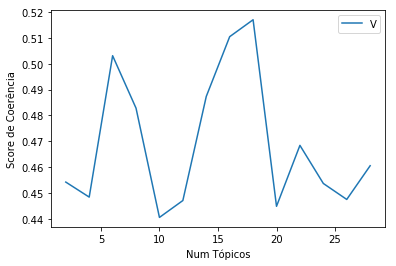

In [34]:
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()

In [35]:
for m, c in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(c, 4))

A quantidade de tópicos = 2  tem um valor de coerência de  0.4542
A quantidade de tópicos = 4  tem um valor de coerência de  0.4484
A quantidade de tópicos = 6  tem um valor de coerência de  0.5031
A quantidade de tópicos = 8  tem um valor de coerência de  0.4828
A quantidade de tópicos = 10  tem um valor de coerência de  0.4405
A quantidade de tópicos = 12  tem um valor de coerência de  0.447
A quantidade de tópicos = 14  tem um valor de coerência de  0.4873
A quantidade de tópicos = 16  tem um valor de coerência de  0.5104
A quantidade de tópicos = 18  tem um valor de coerência de  0.517
A quantidade de tópicos = 20  tem um valor de coerência de  0.4448
A quantidade de tópicos = 22  tem um valor de coerência de  0.4684
A quantidade de tópicos = 24  tem um valor de coerência de  0.4536
A quantidade de tópicos = 26  tem um valor de coerência de  0.4475
A quantidade de tópicos = 28  tem um valor de coerência de  0.4605


16 ou 18 tópicos

In [149]:
dtm = cv.fit_transform(item_licitacao['DS_ITEM_TOKEN'])
LDA = LatentDirichletAllocation(n_components=10,random_state=42)
LDA.fit(dtm)
LDA.components_
single_topic = LDA.components_[0]
# Returns the indices that would sort this array.
single_topic.argsort()
top_word_indices = single_topic.argsort()[-10:]
for index in top_word_indices:
    print(cv.get_feature_names()[index])


editora
casca
verde
primeira
mão
parafuso
grau
obra
livro
médio


In [150]:
#LDA Antes
topic_results = LDA.transform(dtm)
item_licitacao['Topic'] = topic_results.argmax(axis=1)
item_licitacao[['DS_ITEM','Topic']].head()

,DS_ITEM,Topic
0,Credenciamento de academias de ginástica e mus...,7
1,PLACA DE OBRA (PARA CONSTRUCAO CIVIL) EM CHAPA...,6
2,TAPUME COM COMPENSADO DE MADEIRA. AF_05/2018,6
3,PODA EM ALTURA DE ÁRVORE COM DIÂMETRO DE TRONC...,4
4,"LOCACAO DE CONTAINER 2,30 X 6,00 M, ALT. 2,5...",6


In [151]:
topic_results

array([[0.00454732, 0.00454581, 0.00454572, ..., 0.95908154, 0.00454676,
        0.00454566],
       [0.01429058, 0.01428571, 0.01428573, ..., 0.01428976, 0.01428574,
        0.21202403],
       [0.025     , 0.02500002, 0.02500027, ..., 0.02500127, 0.025     ,
        0.025     ],
       ...,
       [0.03333811, 0.03333333, 0.03333513, ..., 0.03334249, 0.03333333,
        0.03334444],
       [0.025     , 0.02501603, 0.02500151, ..., 0.025     , 0.02502592,
        0.77494199],
       [0.025     , 0.02500524, 0.02500037, ..., 0.025     , 0.02501024,
        0.77497758]])

In [152]:
for index,topic in enumerate(LDA.components_):
    print(f'Top 10 tópicos dos itens#{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 tópicos dos itens#0
['editora', 'casca', 'verde', 'primeira', 'mão', 'parafuso', 'grau', 'obra', 'livro', 'médio']


Top 10 tópicos dos itens#1
['azul', 'folha', 'saco', 'caixa', 'cloridrato', 'folhas', 'comprimido', 'solução', 'frasco', 'papel']


Top 10 tópicos dos itens#2
['ponta', 'alta', 'carga', 'garantia', 'inmetro', 'lonas', 'mínima', 'capacidade', 'mínimo', 'pneu']


Top 10 tópicos dos itens#3
['prazo', 'contendo', 'mínimo', 'fabricação', 'mínima', 'entrega', 'meses', 'produto', 'validade', 'embalagem']


Top 10 tópicos dos itens#4
['água', 'resina', 'pasta', 'tubo', 'pintura', 'massa', 'base', 'embalagem', 'tinta', 'concreto']


Top 10 tópicos dos itens#5
['bucha', 'material', 'metros', 'inox', 'largura', 'madeira', 'altura', 'comprimento', 'cabo', 'aço']


Top 10 tópicos dos itens#6
['cotação', 'documentação', 'reforma', 'construção', 'fornecimento', 'especificações', 'tubo', 'instalação', 'termo', 'pvc']


Top 10 tópicos dos itens#7
['manutenção', 'locação', 'municíp

In [153]:
lda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=5, 
                        random_state=100,
                        per_word_topics=True)

In [154]:
lda_model2 = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=16, 
                        random_state=100,
                        per_word_topics=True)

Mais uma filtragem

In [155]:
filter_out = filter_out + ['ca', 'cx', 'ser', 'novo', 'ano', 'gr', 'deve', 'data', 'contar', 'resistente', 'partir', 'in', 'boa', 'limpa', 'qualidade', 'tamanho', 'apresentar', 'estar']

In [156]:
lic2= [d.split() for d in item_licitacao['DS_ITEM_TOKEN'] if d not in filter_out]

In [157]:
id2word2 = corpora.Dictionary(lic2)
corpus2 = [id2word2.doc2bow(text.split()) for text in texts]
[[(id2word2[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[("'academias',", 1),
  ("'cada',", 1),
  ("'canoas',", 1),
  ("'credenciado',", 1),
  ("'desembolsado',", 1),
  ("'escolhido',", 1),
  ("'estabelecimento',", 2),
  ("'exercícios',", 1),
  ("'físicos',", 1),
  ("'ginástica',", 1),
  ("'matriculado',", 1),
  ("'ministrem',", 1),
  ("'município',", 3),
  ("'musculação',", 1),
  ("'outro',", 1),
  ("'r',", 1),
  ("'servidor',", 1),
  ("'servidor']", 1),
  ("'valor',", 1),
  ("'âmbito',", 1),
  ("['credenciamento',", 1)]]

In [158]:
lda_model3 = LdaMulticore(corpus=corpus2,
                        id2word=id2word2,
                        num_topics=6, 
                        random_state=100,
                        per_word_topics=True)

Salvar modelos

In [159]:
import joblib
joblib.dump(LDA, 'LDA_sem_multicore.jl')

['LDA_sem_multicore.jl']

In [160]:
lda_model.save('multicore1_5topics')

In [161]:
lda_model2.save('multicore2_16topics')

In [162]:
lda_model3.save('multicore3_16topics')

Carregar Modelos

In [163]:
from gensim.test.utils import datapath

In [164]:
LDA = joblib.load('LDA_sem_multicore.jl')

In [165]:
lda_model = LdaMulticore.load(datapath("/Users/ionasantana/Documents/GitHub/Artificial-Intelligence/Projects/NLP/multicore1_5topics")) 

In [166]:
lda_model2 = LdaMulticore.load(datapath("/Users/ionasantana/Documents/GitHub/Artificial-Intelligence/Projects/NLP/multicore2_16topics")) 

In [167]:
lda_model3 = LdaMulticore.load(datapath("/Users/ionasantana/Documents/GitHub/Artificial-Intelligence/Projects/NLP/multicore3_16topics")) 

Após o processamento, se encontrou palavras como cor, un, af, tipo - então elas foram adicionadas no filtro e foi se processado novamente

In [168]:
item_licitacao.to_csv('lda.csv') #lda1, LatentDirichletAllocation

In [169]:
#função Score de Coerência
def score_coherence (lda_model,lic,id2word):
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lic, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nScore de Coerência: ', coherence_lda)

Comparação dos 3 modelos treinados de lda

In [170]:
score_coherence(lda_model,lic,id2word)


Score de Coerência:  0.45312188484744603


In [171]:
score_coherence(lda_model2, lic, id2word)


Score de Coerência:  0.48965680345355667


Com 6 clusters e algumas stopwords adicionadas a mais, teve desempenho melhor que o primeiro com 5 clusters e um pouco pior que o segundo com 16 cluster.

In [172]:
score_coherence(lda_model3, lic2, id2word2)


Score de Coerência:  0.47012530959324517


In [173]:
pyLDAvis.enable_notebook()

In [183]:
display_data = pyLDAvis.sklearn.prepare(LDA, cv.fit_transform(item_licitacao['DS_ITEM_TOKEN']), cv) #LDA -> lda_model

In [186]:
import warnings
warnings.filterwarnings("ignore")

In [187]:
display_data_lda2 = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word) #LDA -> lda_model

/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp im

In [188]:
display_data_lda3 = pyLDAvis.gensim_models.prepare(lda_model2, corpus, id2word) #LDA -> lda_model

/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this w

In [189]:
display_data_lda4 = pyLDAvis.gensim_models.prepare(lda_model3, corpus2, id2word2)

/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from numpy import (exp, inf, pi, sqrt, floor, sin, cos, around, int,
/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-package

In [ ]:
pyLDAvis.display(display_data)  

In [ ]:
pyLDAvis.display(display_data_lda2)  

In [ ]:
pyLDAvis.display(display_data_lda3) 

Pode ser separado em 5

In [ ]:
pyLDAvis.display(display_data_lda4)  

In [ ]:
item_licitacao.to_csv('lda_multicore.csv')

Qual a diferença entre LDA e NMF?


Desvendando o latent Dirichlet Allocation - https://web.icmc.usp.br

O objetivo é esclarecer essa relação em termos de formulação matemática, demonstrando que o NMF com divergência KL aproxima a solução obtida pelo algoritmo de inferência variacional do LDA.

As correspondências entre NMF com divergência KL e o algoritmo de inferência variacio- nal para o LDA seguem do fato de que ambos tentam minimizar a divergência entre as estatísticas que relacionam a frequência de palavras, documentos por tópicos e tópicos por palavras. 

NMF

In [119]:
from gensim.models.nmf import Nmf as GensimNmf

In [127]:
nmf_model = GensimNmf(
    corpus=corpus2,
    num_topics=6,
    id2word=id2word2,
    random_state = 42,
)    

In [190]:
nmf_model.show_topics(formatted=False)

[(0,
  [("',", 0.07140993559793476),
   ("['", 0.05774081097531963),
   ("'\\t',", 0.021238394409694255),
   ("'r',", 0.012281131022839899),
   ("'\\t", 0.011258320808000606),
   ("'un',", 0.00888694187218245),
   ("'serviços',", 0.007519348078450517),
   ("'c',", 0.006780843597725328),
   ("'conforme',", 0.004625552104679766),
   ("'serviço',", 0.004353996312308105)]),
 (1,
  [("'cor',", 0.02178463798400394),
   ("'ser',", 0.013609292959828191),
   ("'deverá',", 0.013084738485455666),
   ("'tamanho',", 0.010684322124849646),
   ("'deve',", 0.00791824623552637),
   ("'possuir',", 0.006390532120293119),
   ("'tecido',", 0.004980764001008545),
   ("'conforme',", 0.004852942170583151),
   ("'apresentar',", 0.004447949014234258),
   ("'qualidade',", 0.004118402238918768)]),
 (2,
  [("'embalagem',", 0.038281267013454544),
   ("'validade',", 0.03486338452792729),
   ("'data',", 0.03181166065580779),
   ("'produto',", 0.02185506335192711),
   ("'mínimo',", 0.0185041261025936),
   ("'meses',",

In [128]:
nmf_model.show_topics()

[(0,
  '0.071*"\'," + 0.058*"[\'" + 0.021*"\'\\t\'," + 0.012*"\'r\'," + 0.011*"\'\\t" + 0.009*"\'un\'," + 0.008*"\'serviços\'," + 0.007*"\'c\'," + 0.005*"\'conforme\'," + 0.004*"\'serviço\',"'),
 (1,
  '0.022*"\'cor\'," + 0.014*"\'ser\'," + 0.013*"\'deverá\'," + 0.011*"\'tamanho\'," + 0.008*"\'deve\'," + 0.006*"\'possuir\'," + 0.005*"\'tecido\'," + 0.005*"\'conforme\'," + 0.004*"\'apresentar\'," + 0.004*"\'qualidade\',"'),
 (2,
  '0.038*"\'embalagem\'," + 0.035*"\'validade\'," + 0.032*"\'data\'," + 0.022*"\'produto\'," + 0.019*"\'mínimo\'," + 0.015*"\'meses\'," + 0.015*"\'mínima\'," + 0.014*"\'fabricação\'," + 0.010*"\'contendo\'," + 0.010*"\'identificação\',"'),
 (3,
  '0.032*"\'tipo\'," + 0.018*"\'aço\'," + 0.009*"\'mínimo\'," + 0.006*"\'material\'," + 0.006*"\'espessura\'," + 0.006*"\'af\'," + 0.005*"\'_\']" + 0.005*"\'sistema\'," + 0.005*"\'capacidade\'," + 0.005*"\'mínima\',"'),
 (4,
  '0.110*"\'x\'," + 0.011*"\'mínimo\'," + 0.008*"\'cor\'," + 0.008*"\'altura\'," + 0.007*"\'dimens

In [133]:
nmf_model.top_topics(corpus2)

[([(0.038281267013454544, "'embalagem',"),
   (0.03486338452792729, "'validade',"),
   (0.03181166065580779, "'data',"),
   (0.02185506335192711, "'produto',"),
   (0.0185041261025936, "'mínimo',"),
   (0.01534672130957364, "'meses',"),
   (0.015219061339868091, "'mínima',"),
   (0.014086300995945064, "'fabricação',"),
   (0.010311694126574913, "'contendo',"),
   (0.010071713877618656, "'identificação',"),
   (0.009690024504321678, "'prazo',"),
   (0.009520131437153861, "'peso',"),
   (0.008806442579477991, "'entrega']"),
   (0.007759453918378447, "'entrega',"),
   (0.007627187279795312, "'lote',"),
   (0.007576438379942781, "'contar',"),
   (0.007531621064739351, "'deve',"),
   (0.007397787301424395, "'registro',"),
   (0.007339767551815246, "'deverá',"),
   (0.007280890628364314, "'ingredientes',")],
  -1.7374400120328346),
 ([(0.02178463798400394, "'cor',"),
   (0.013609292959828191, "'ser',"),
   (0.013084738485455666, "'deverá',"),
   (0.010684322124849646, "'tamanho',"),
   (0.00

In [136]:
nmf_model.save('nmf_model1')

In [137]:
nmf_model = GensimNmf.load('nmf_model1')

In [134]:
item_licitacao[['DS_ITEM','Topic_nfm']].head(10)

,DS_ITEM,Topic_nfm
0,Credenciamento de academias de ginástica e mus...,4
1,PLACA DE OBRA (PARA CONSTRUCAO CIVIL) EM CHAPA...,2
2,TAPUME COM COMPENSADO DE MADEIRA. AF_05/2018,2
3,PODA EM ALTURA DE ÁRVORE COM DIÂMETRO DE TRONC...,3
4,"LOCACAO DE CONTAINER 2,30 X 6,00 M, ALT. 2,5...",9
5,"LOCACAO CONVENCIONAL DE OBRA, UTILIZANDO GABAR...",4
6,RECOMPOSIÇÃO PARCIAL DE ARAME FARPADO Nº 14 CL...,3
7,"LIMPEZA MECANIZADA DE CAMADA VEGETAL, VEGETAÇÃ...",7
8,ARQUITETO PLENO,4
9,ENCARREGADO GERAL DE OBRAS,4


In [135]:
item_licitacao[['DS_ITEM_TOKEN','Topic_nfm']].head(10)

,DS_ITEM_TOKEN,Topic_nfm
0,"['credenciamento', 'academias', 'ginástica', '...",4
1,"['placa', 'obra', 'construcao', 'civil', 'chap...",2
2,"['tapume', 'compensado', 'madeira', 'af', '_']",2
3,"['poda', 'altura', 'árvore', 'diâmetro', 'tron...",3
4,"['locacao', 'container', 'x', 'alt', 'escritor...",9
5,"['locacao', 'convencional', 'obra', 'utilizand...",4
6,"['recomposição', 'parcial', 'arame', 'farpado'...",3
7,"['limpeza', 'mecanizada', 'camada', 'vegetal',...",7
8,"['arquiteto', 'pleno']",4
9,"['encarregado', 'geral', 'obras']",4


In [139]:
item_licitacao.to_csv('nfm1.csv')

Coerência NFM

In [145]:
coerencia_nmf = cm = CoherenceModel(
    model=nmf_model,
    corpus=corpus2,
    coherence='u_mass',
).get_coherence()
    

In [146]:
coerencia_nmf

-3.2800099938832066

Wordclouds

In [199]:
import matplotlib.colors as mcolors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

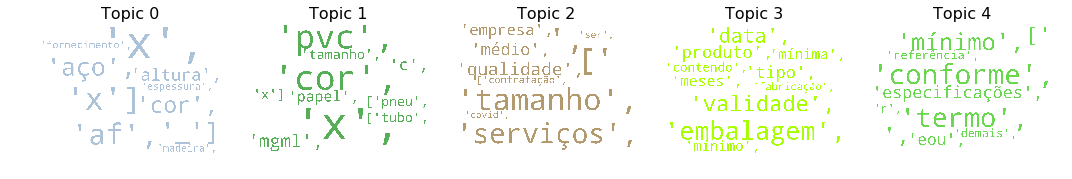

In [209]:
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
cloud = WordCloud(stopwords=filter_out,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = lda_model.show_topics(formatted=False)
fig, axes = plt.subplots(1, 5, figsize=(15,15), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=600)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Como pode notar, algumas palavras como 'x', ']', ainda permaneceram no texto, atrapalhando os resultados

K-means

### Análise dos dados

Comparar os tópicos entre os dois

### Conclusão

Counter Vectorizarion -> contar a ocorrência de cada palavra para mapear o texto para um número

CounterVectorizer

TfidfVectorizer -> cria a mais uma matriz de termos de documento a partir de nossas mensagens.
No entanto, em vez de preencher o DTM com contagens de token, ele calcula o valor da frequência do documento inverso da frequência do termo para cada palavra (TF-IDF).
Um fator de frequência de documento inverso é incorporado, o que diminui o peso dos termos que ocorrem com muita frequência no conjunto de documentos e aumenta o peso dos termos que ocorrem raramente.


Quais foram as áreas com maiores investimentos?

E quais foram os principais itens licitados nelas?